# Fit Multiple Noisy Traces HH to HH

In [1]:
import pandas as pd
import numpy as np

In [2]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [3]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

dt = 0.01*ms
defaultclock.dt = dt

In [4]:
params_correct

{'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}

### Load Input and Output

In [5]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [6]:
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[:, 1:]
inp_traces

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e-09, 2.e-09, 2.e-09, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]])

In [7]:
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[:, 1:]
out_traces

array([[-63.54211145, -65.52491616, -62.90054542, ..., -81.5252667 ,
        -82.30107475, -82.04870895],
       [-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384],
       [-62.92648395, -65.82540807, -64.76394825, ..., -64.9418292 ,
        -63.8704734 , -63.17105741],
       [-64.51645049, -66.84945425, -64.64260378, ..., -80.91299455,
        -79.08977935, -82.01562544],
       [-65.57417095, -65.68558642, -65.67498994, ..., -59.60054522,
        -60.47494105, -60.01392187]])

## Model Fitting 

In [8]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
''',
# El  : volt(constant)
# EK  : volt(constant)
# ENa : volt(constant)
# Cm=1*ufarad*cm**-2 * area,
El=-65*mV, EK=-90*mV, ENa=50*mV,
VT=-63*mV)

In [9]:
start_scope()
n_opt = NevergradOptimizer(method='TwoPointsDE')
metric = MSEMetric()

res, error = fit_traces(model=eqs, input_var='I', output_var='v',
                       input=inp_traces * amp, output=out_traces*mV, dt=dt,
                       method='exponential_euler',
                       gl = [1e-09 *siemens, 1e-07 *siemens],
                       g_na = [2e-06*siemens, 2e-04*siemens],
                       g_kd = [6e-07*siemens, 6e-05*siemens],
                       Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
#                      El=[-100*mV, -60*mV],
#                      EK=[-100*mV, -60*mV],
#                      ENa=[30*mV, 55*mV],
                       n_rounds=10, n_samples=30, optimizer=n_opt, 
                       metric=metric)

round 0 with error 0.8223223110685904
parameters: {'g_na': 5.928622899037485e-05, 'g_kd': 4.5353447877419137e-05, 'gl': 4.245107442661426e-08, 'Cm': 1.7586431933713058e-10}
round 1 with error 0.909132580526227
parameters: {'g_na': 5.928622899037485e-05, 'g_kd': 4.5353447877419137e-05, 'gl': 4.245107442661426e-08, 'Cm': 1.7586431933713058e-10}
round 2 with error 0.8616486404230528
parameters: {'g_na': 5.928622899037485e-05, 'g_kd': 4.5353447877419137e-05, 'gl': 4.245107442661426e-08, 'Cm': 1.7586431933713058e-10}
round 3 with error 0.9023044403693401
parameters: {'g_na': 5.928622899037485e-05, 'g_kd': 4.5353447877419137e-05, 'gl': 4.245107442661426e-08, 'Cm': 1.7586431933713058e-10}
round 4 with error 0.757808368558781
parameters: {'g_na': 4.47469533315752e-05, 'g_kd': 2.7603079490791868e-05, 'gl': 6.060116416651081e-08, 'Cm': 1.9138804986308664e-10}
round 5 with error 0.757808368558781
parameters: {'g_na': 5.928622899037485e-05, 'g_kd': 4.5353447877419137e-05, 'gl': 4.2441408809706284e

In [10]:
# get information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'g_na': 2.3027127196187944e-05, 'g_kd': 1.6977690217230132e-05, 'gl': 7.54091313876362e-08, 'Cm': 2.0124673281215325e-10}
error 0.7593740989774654


## Results Visualization

In [11]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_traces * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v': -65*mV})

fits/mV

array([[-65.        , -65.        , -65.        , ..., -70.8556826 ,
        -70.83378098, -70.81196122],
       [-65.        , -65.        , -65.        , ..., -64.75728969,
        -64.75807945, -64.75886626],
       [-65.        , -64.90080547, -64.80198193, ..., -64.91710241,
        -64.91730481, -64.91750642],
       [-65.        , -65.        , -65.        , ..., -69.29591113,
        -69.27983806, -69.26382503],
       [-65.        , -65.        , -65.        , ..., -64.59650611,
        -64.59787853, -64.59924592]])

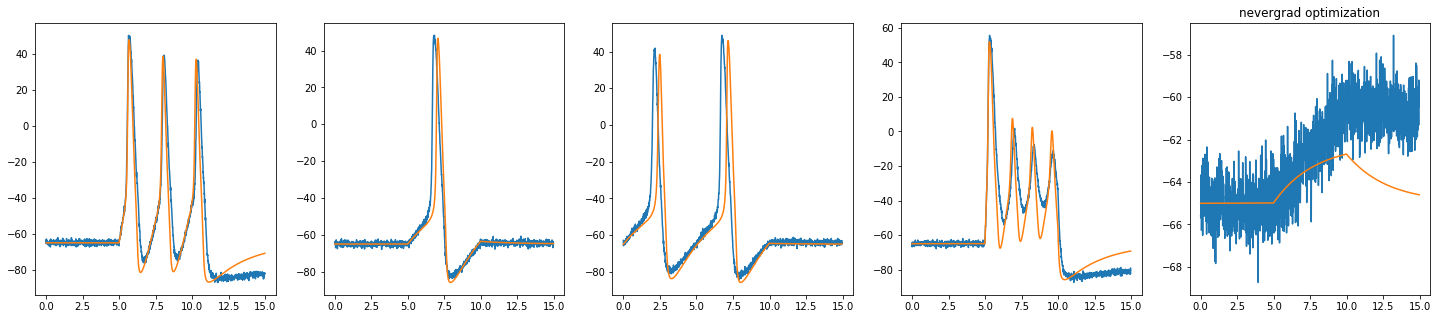

In [12]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 5))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);

ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);

ax[2].plot(np.arange(len(out_traces[2]))*dt/ms, out_traces[2]);
ax[2].plot(np.arange(len(fits[2]))*dt/ms, fits[2]/mV);

ax[3].plot(np.arange(len(out_traces[3]))*dt/ms, out_traces[3]);
ax[3].plot(np.arange(len(fits[3]))*dt/ms, fits[3]/mV);

ax[4].plot(np.arange(len(out_traces[4]))*dt/ms, out_traces[4]);
ax[4].plot(np.arange(len(fits[4]))*dt/ms, fits[4]/mV);

plt.title('nevergrad optimization')
plt.show()

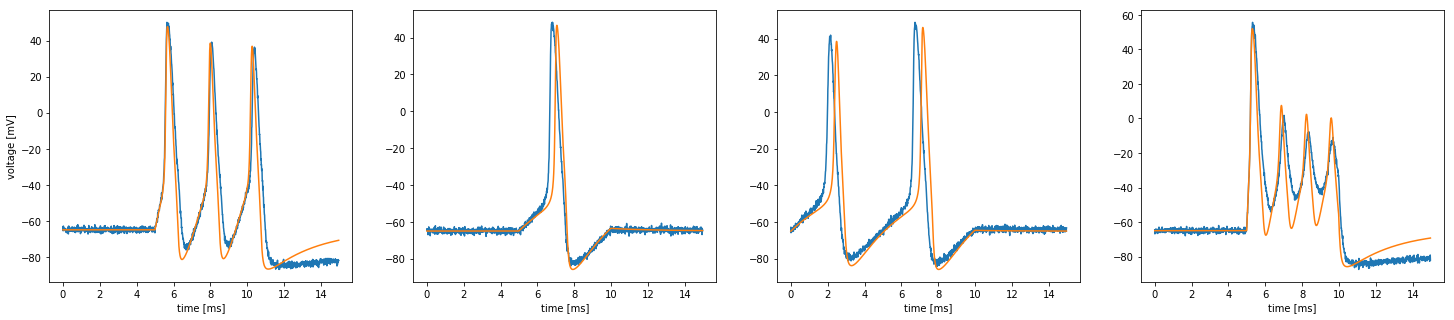

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);

ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);

ax[2].plot(np.arange(len(out_traces[2]))*dt/ms, out_traces[2]);
ax[2].plot(np.arange(len(fits[2]))*dt/ms, fits[2]/mV);

ax[3].plot(np.arange(len(out_traces[3]))*dt/ms, out_traces[3]);
ax[3].plot(np.arange(len(fits[3]))*dt/ms, fits[3]/mV);

ax[0].set_ylabel('voltage [mV]')
# ax[1].set_ylabel('voltage [mV]')
# ax[2].set_ylabel('voltage [mV]')
# ax[3].set_ylabel('voltage [mV]')

ax[0].set_xlabel('time [ms]')
ax[1].set_xlabel('time [ms]')
ax[2].set_xlabel('time [ms]')
ax[3].set_xlabel('time [ms]');
fig.savefig('fit_traces_example.png')